<a href="https://colab.research.google.com/github/Jayavathsan/DeepLearning/blob/main/PyTorch/GAN/STL10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN GAN with STL10


In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
%matplotlib notebook

In [3]:
%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the data

In [5]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Resize(64),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.STL10(root='./data', download=True, transform=transform)

# transform to dataloaders
batchSize   = 64
dataLoader = DataLoader(dataset,batch_size=batchSize,shuffle=True,drop_last=True)

100%|██████████| 2640397119/2640397119 [01:00<00:00, 43742458.48it/s]


Extracting ./data/stl10_binary.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


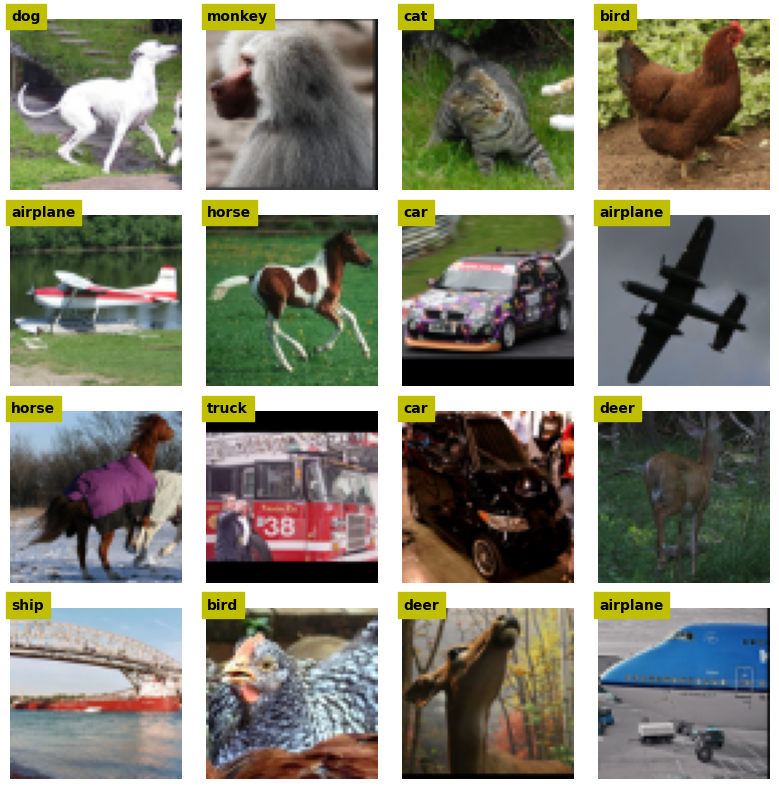

In [6]:
# inspect a few random images

x,y = next(iter(dataLoader))

fig,axs = plt.subplots(4,4,figsize=(8,8))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = x.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = dataset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Create classes for the discriminator and generator

In [7]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  3, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.batchNorm2 = nn.BatchNorm2d(128)
    self.batchNorm3 = nn.BatchNorm2d(256)
    self.batchNorm4 = nn.BatchNorm2d(512)

  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.batchNorm2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.batchNorm3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.batchNorm4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


discriminator = discriminatorNet()
y = discriminator(torch.randn(10,3,64,64))
y.shape

torch.Size([10, 1])

torch.Size([10, 3, 64, 64])


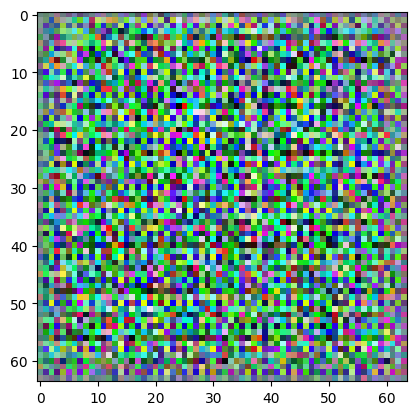

In [8]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   3, 4, 2, 1, bias=False)

    # batchnorm
    self.batchNorm1 = nn.BatchNorm2d(512)
    self.batchNorm2 = nn.BatchNorm2d(256)
    self.batchNorm3 = nn.BatchNorm2d(128)
    self.batchNorm4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.batchNorm1(self.conv1(x)) )
    x = F.relu( self.batchNorm2(self.conv2(x)) )
    x = F.relu( self.batchNorm3(self.conv3(x)) )
    x = F.relu( self.batchNorm4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x


generator = generatorNet()
y = generator(torch.randn(10,100,1,1))
print(y.shape)
pic = y[0,:,:,:].squeeze().detach().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
plt.imshow(pic);

# Train the models!

In [9]:
lossFunction = nn.BCELoss()

discriminator = discriminatorNet().to(device)
generator = generatorNet().to(device)

discriminateOptimizer = torch.optim.Adam(discriminator.parameters(), lr=.0002, betas=(.5,.999)) # betas can be removed
generateOptimizer = torch.optim.Adam(generator.parameters(), lr=.0002, betas=(.5,.999))

In [10]:
len(dataLoader)

78

In [11]:
# number of epochs
numEpochs = 50

losses  = []
disDecs = []

for i in range(numEpochs):

  for data,_ in dataLoader:

    # send data to GPU
    data = data.to(device)

    # create labels for real and fake images
    realLabels = torch.ones(batchSize,1).to(device)
    fakeLabels = torch.zeros(batchSize,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    realPrediction   = discriminator(data)                     # output of discriminator
    realDiscriminatorLoss = lossFunction(realPrediction,realLabels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fakeData   = torch.randn(batchSize,100,1,1).to(device) # random numbers to seed the generator
    fakeImages = generator(fakeData)                           # output of generator
    fakePredictions   = discriminator(fakeImages)                         # pass through discriminator
    fakeDiscriminatorLoss = lossFunction(fakePredictions,fakeLabels)            # all labels are 0

    # collect loss (using combined losses)
    discriminatorLoss = realDiscriminatorLoss + fakeDiscriminatorLoss

    # backprop
    discriminateOptimizer.zero_grad()
    discriminatorLoss.backward()
    discriminateOptimizer.step()



    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fakeImages = generator( torch.randn(batchSize,100,1,1).to(device) )
    fakePredictions   = discriminator(fakeImages)

    # compute loss
    generatorLoss = lossFunction(fakePredictions,realLabels)

    # backprop
    generateOptimizer.zero_grad()
    generatorLoss.backward()
    generateOptimizer.step()


    # collect losses and discriminator decisions
    losses.append([discriminatorLoss.item(),generatorLoss.item()])

    d1 = torch.mean((realPrediction>.5).float()).detach().cpu()
    d2 = torch.mean((fakePredictions>.5).float()).detach().cpu()
    disDecs.append([d1,d2])

  # print out a status message
  msg = f'Finished epoch {i+1}/{numEpochs}'
  sys.stdout.write('\r' + msg)


Finished epoch 50/50

In [12]:
# convert performance from list to numpy array
losses  = np.array(losses)
disDecs = np.array(disDecs)

In [13]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

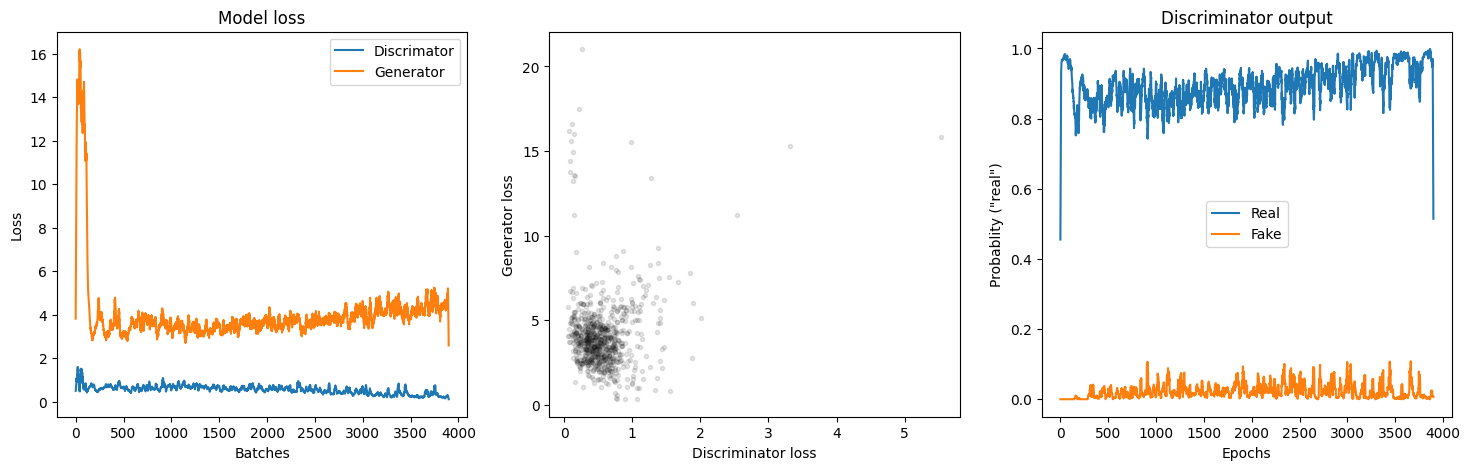

In [14]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([1500,2000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

# Generated images

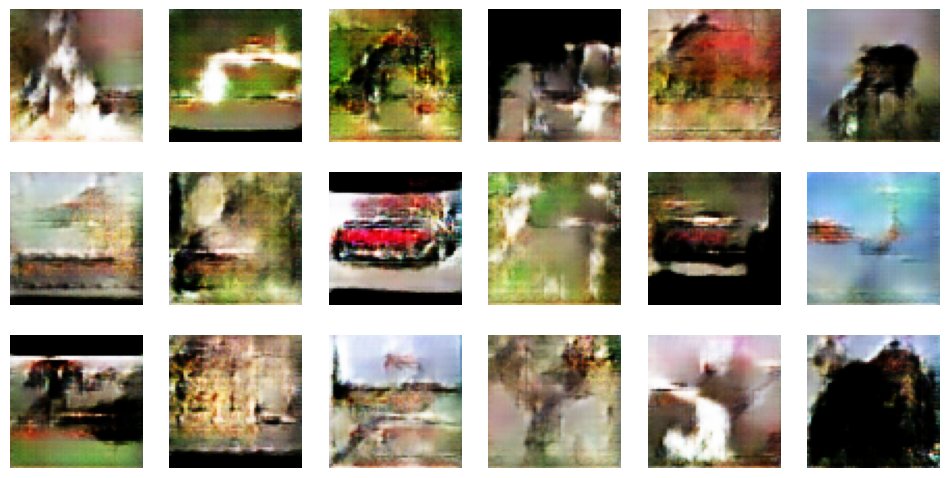

In [15]:
# generate the images from the generator network
generator.eval()
fakeData = generator( torch.randn(batchSize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  pic = fakeData[i,:,].detach().squeeze().numpy().transpose((1,2,0))
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  ax.imshow(pic,cmap='gray')
  ax.axis('off')

plt.show()

# This model architecture and meta-parameter choices were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html